In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad

from copy import deepcopy
from glob import glob

In [3]:
adata = ad.read_h5ad('../data/cellbender/combined.h5ad.gz')

In [5]:

# single cell preprocessing functions
def perform_qc(adata, filter_cells=False):
    # calculate qc metrics
    adata.var["mt"] = adata.var_names.str.startswith(
        "MT-"
    )  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt"], percent_top=None, log1p=True, inplace=True
    )
    sc.pl.highest_expr_genes(adata, save="prefilter")
    # plot qc metrics
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "log1p_total_counts", "total_counts"],
        stripplot=False,
        multi_panel=True,
        save="prefilter",
    )
    adata.obs["log10_total_counts"] = np.log10(adata.obs["total_counts"] + 1)
    adata.obs["log10_n_genes"] = np.log10(adata.obs["n_genes"] + 1)
    if filter_cells == True:
        sc.pp.filter_cells(adata, min_counts=1000)
        sc.pp.filter_cells(adata, min_genes=300)
        sc.pp.filter_cells(adata, max_genes=9000)
        sc.pp.filter_cells(adata, max_counts=89000)
    adata = adata[adata.obs["pct_counts_mt"] < 12]
    # plot results of filtering
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "log1p_total_counts", "total_counts"],
        stripplot=False,
        multi_panel=True,
        save="postfilter",
    )
    sc.pl.highest_expr_genes(adata, save="postfilter")
    return adata

def cluster_anndata(adata, batch_correct=False, batch_key="sample_uid"):
    print("PCA-ing")
    sc.pp.pca(adata)
    print("drawing neighbor graph")
    if batch_correct == True:
        print("batch corrected neighbors")
        sce.pp.bbknn(adata, batch_key=batch_key)
    else:
        sc.pp.neighbors(adata, n_neighbors=20)
    print("UMAP-ing")
    sc.tl.umap(adata)
    print("leiden-ing")
    sc.tl.leiden(adata, resolution=0.2)
    return adata


def add_samplesheet(file, adata):
    samplesheets = pd.read_table(file)

    samplesheets["sample_uid"] = (
        samplesheets["donor"]
        + "_"
        + samplesheets["sample_type"]
        + "_"
        + samplesheets["sample_descriptor"]
    )

    samplesheets.set_index("sample_uid", inplace=True)

    for column in samplesheets.columns:
        _dict = samplesheets[column].to_dict()
        adata.obs[column] = adata.obs.sample_uid.map(_dict)
    return adata


def recluster(adata, batch_correct):
    sc.pp.pca(adata)
    print("constructing neighbors graph")
    if batch_correct == True:
        sc.external.pp.bbknn(adata, batch_key="sample_uid")
    else:
        sc.pp.neighbors(adata, n_neighbors=10)
    print("calculating umap")
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.2)
    return adata

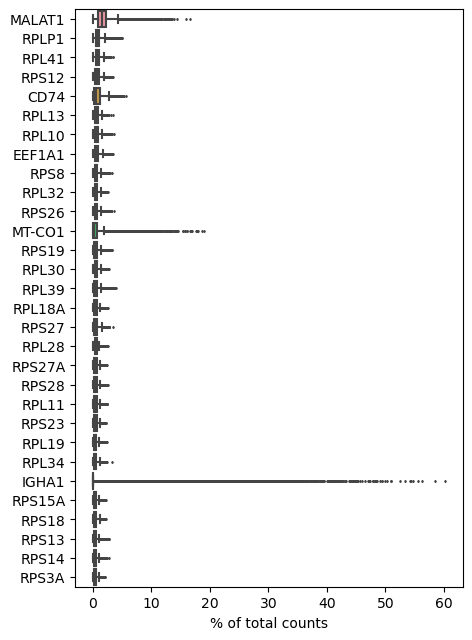

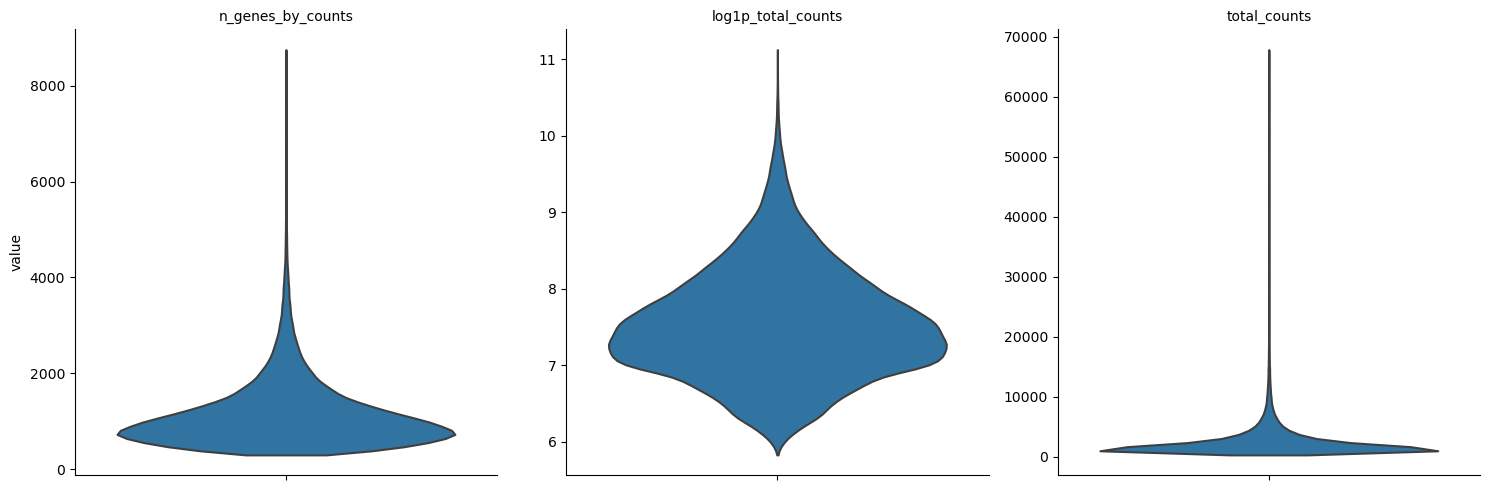

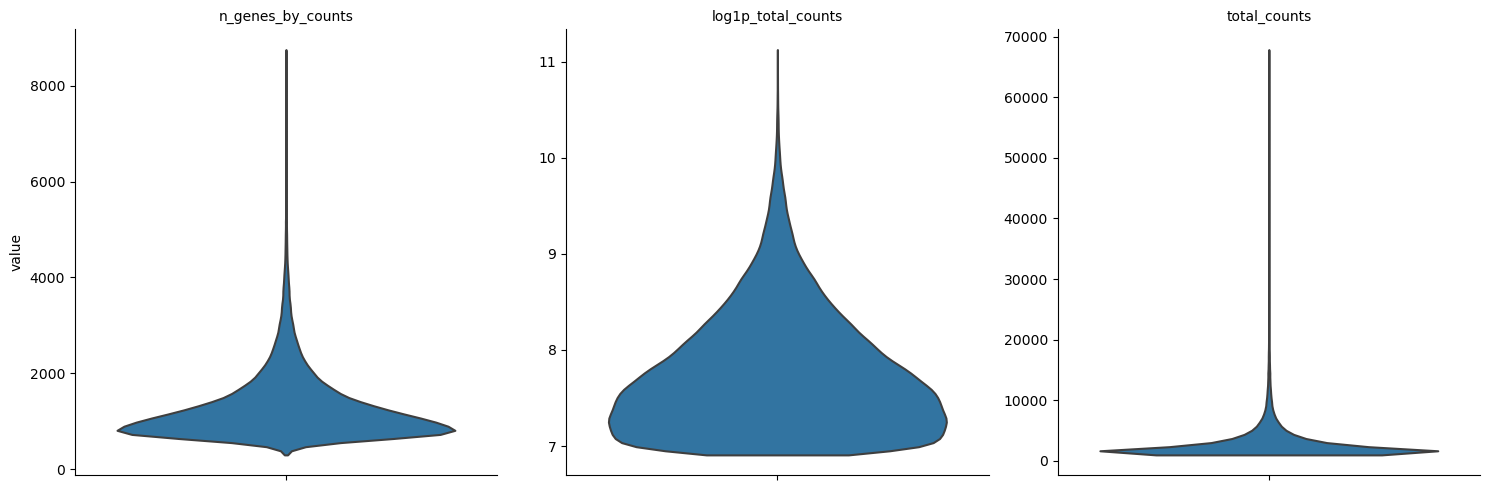

/Users/ivanacvijovic/miniconda3/envs/sc2/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


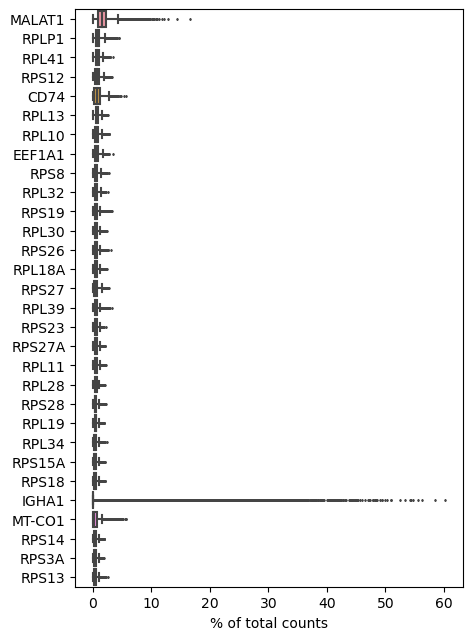

transforming gene expression


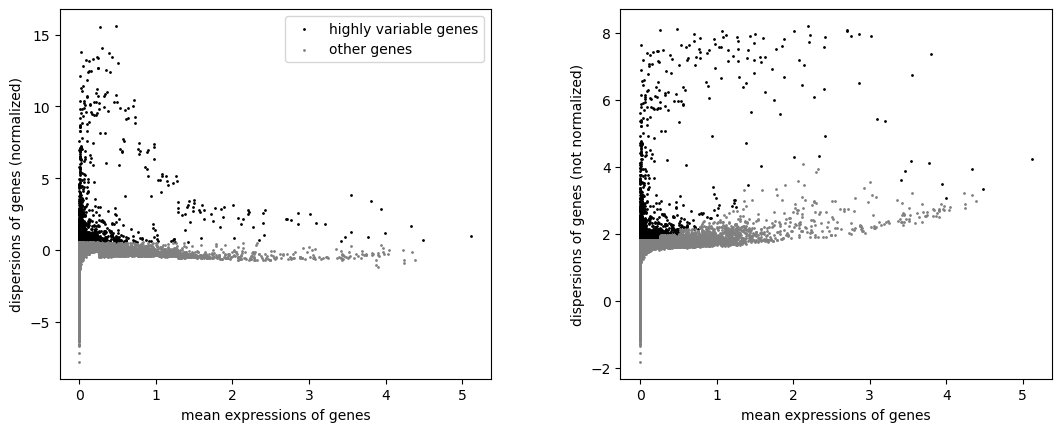

In [9]:
min_genes = 300
min_counts = 100

adata.var_names_make_unique()

# filter very leniently
sc.pp.filter_cells(adata, min_genes = min_genes)
sc.pp.filter_cells(adata, min_counts = min_counts)
adata = perform_qc(adata, filter_cells=True)

adata.var_names_make_unique()

print("transforming gene expression")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata, base=2, chunk_size=10000)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pl.highly_variable_genes(adata)
adata.raw = adata
sc.pp.scale(adata, max_value=10)

In [10]:
import celltypist
from celltypist import models

In [12]:
# Re-annotate new object
anno_1 = "celltypist"
models.download_models()
predictions = celltypist.annotate(
    adata, model="Immune_All_Low.pkl", majority_voting=True
)


📂 Storing models in /Users/ivanacvijovic/.celltypist/data/models
⏩ Skipping [1/12]: Immune_All_Low.pkl (file exists)
⏩ Skipping [2/12]: Immune_All_High.pkl (file exists)
⏩ Skipping [3/12]: Adult_Mouse_Gut.pkl (file exists)
⏩ Skipping [4/12]: COVID19_Immune_Landscape.pkl (file exists)
⏩ Skipping [5/12]: Cells_Fetal_Lung.pkl (file exists)
⏩ Skipping [6/12]: Cells_Intestinal_Tract.pkl (file exists)
⏩ Skipping [7/12]: Cells_Lung_Airway.pkl (file exists)
⏩ Skipping [8/12]: Developing_Mouse_Brain.pkl (file exists)
⏩ Skipping [9/12]: Healthy_COVID19_PBMC.pkl (file exists)
⏩ Skipping [10/12]: Human_Lung_Atlas.pkl (file exists)
⏩ Skipping [11/12]: Nuclei_Lung_Airway.pkl (file exists)
⏩ Skipping [12/12]: Pan_Fetal_Human.pkl (file exists)
👀 Detected scaled expression in the input data, will try the .raw attribute
🔬 Input data has 117140 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 

In [18]:
adata = predictions.to_adata(insert_labels = True, insert_conf = True)
adata.obs[anno_1] = adata.obs['majority_voting']

In [20]:
adata = cluster_anndata(adata, batch_correct=True, batch_key="sample_uid")

PCA-ing
drawing neighbor graph
batch corrected neighbors
UMAP-ing
leiden-ing


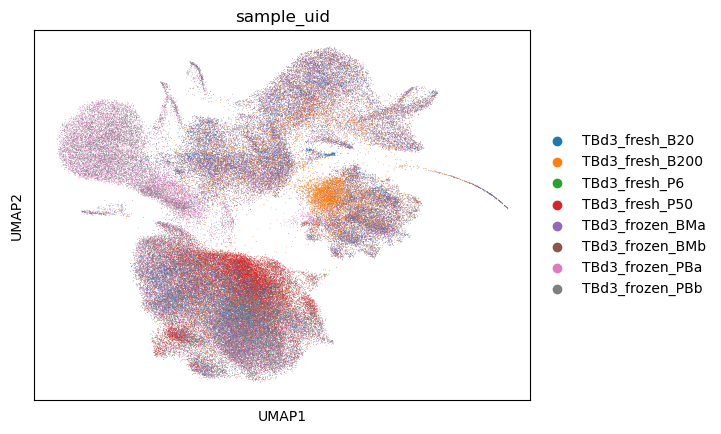

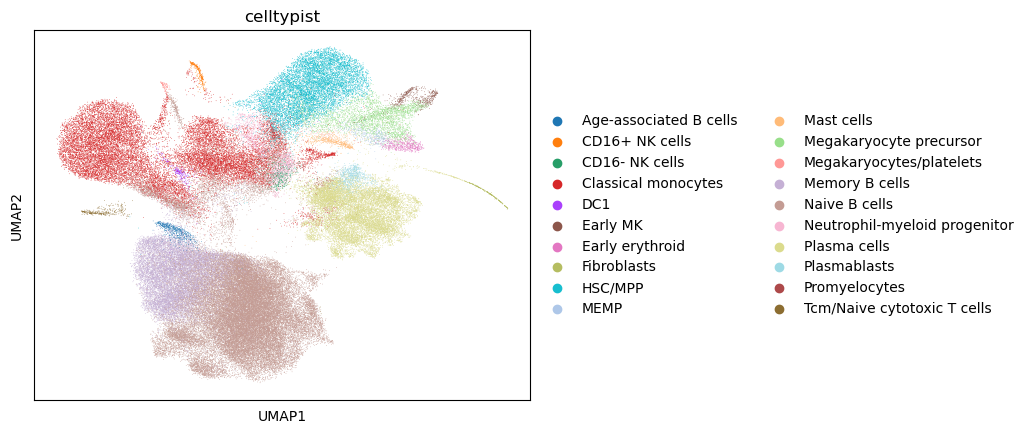

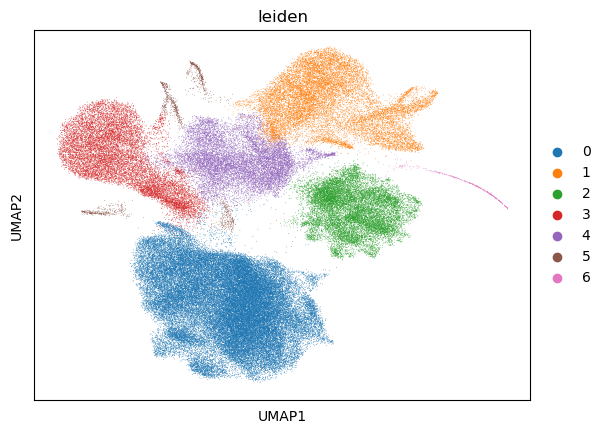

In [21]:
sc.pl.umap(adata, color=['sample_uid'])
sc.pl.umap(adata, color=['celltypist'])
sc.pl.umap(adata, color=['leiden'])

In [23]:
adata = adata[adata.obs.celltypist.str.contains("B cell|Plasma")]

In [32]:
adata = recluster(adata, batch_correct=True)

constructing neighbors graph
calculating umap


Plasma cells
Plasmablasts
Naive B cells
Memory B cells
Age-associated B cells


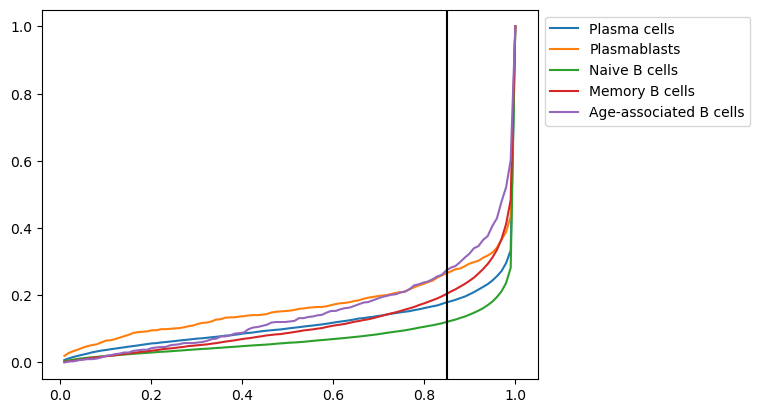

In [33]:
fig, ax = plt.subplots()
for label in adata.obs.celltypist.unique():
    print(label)
    vals = adata[adata.obs.celltypist==label].obs.conf_score
    counts, bins = np.histogram(vals, bins= np.linspace(0,1,100))
    ax.plot(bins[1:], np.cumsum(counts)/counts.sum(), label=label)
# ax.set_yscale('log')
ax.axvline(0.85, color='k')
# ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1,1))

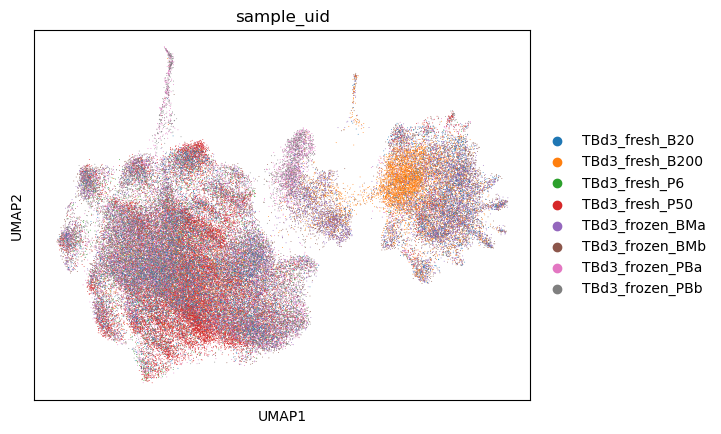

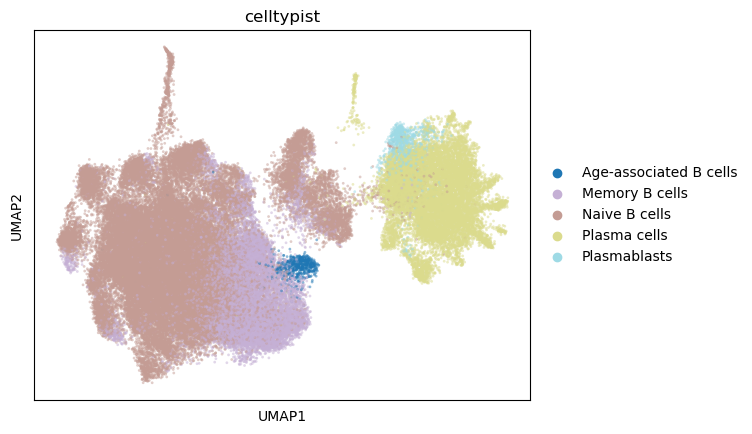

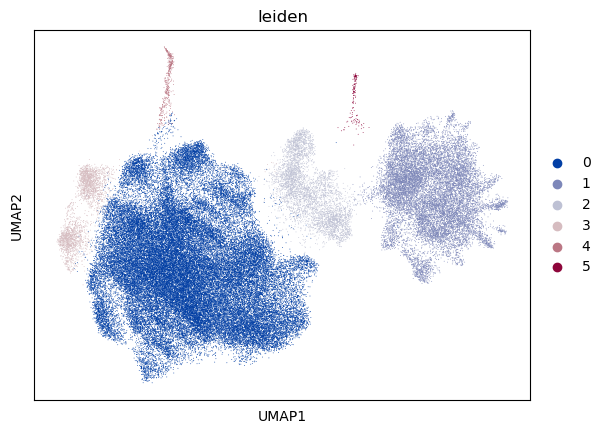

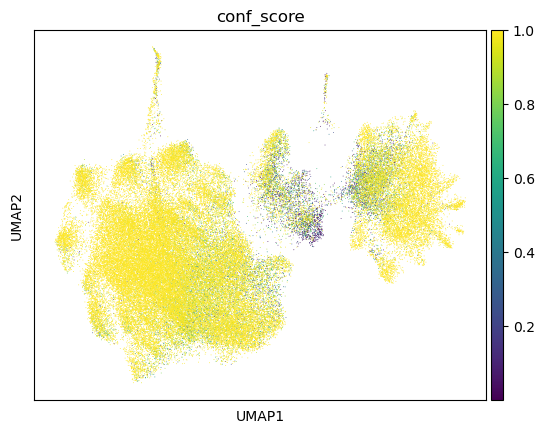

In [34]:
sc.pl.umap(adata, color=['sample_uid'])
sc.pl.umap(adata, color=['celltypist'], size=16, alpha=0.5)
sc.pl.umap(adata, color=['leiden'])
sc.pl.umap(adata, color=['conf_score'])